In [1]:
import tensorflow as tf

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.set_visible_devices(physical_devices[1:],'GPU')

tf.executing_eagerly()
print(tf.executing_eagerly())

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import math
import random
import time
import functools

mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['axes.grid'] = False

from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import datasets, Input, layers, models, Model, losses
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM
from IPython import display
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

True


In [2]:
physical_devices = tf.config.list_physical_devices('GPU') 
for gpu_instance in physical_devices: 
    tf.config.experimental.set_memory_growth(gpu_instance, True)

tf.device('/GPU:1')
tf.config.experimental.list_physical_devices('GPU')

strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


# Input data stream

In [3]:
input_params = data = pd.read_table('input_data/condition.txt', header = None)

datasetNo = int(input_params.values[5,2])
n_epochs = int(input_params.values[10,2])
batch_size = int(input_params.values[11,2])
LR =float(input_params.values[12,2])
Lv1_latent_dim = int(input_params.values[13,2])

num_param = int(input_params.values[1,2])
num_time = int(input_params.values[2,2])
num_node = int(input_params.values[3,2])
num_var = int(input_params.values[4,2])

print('num_param : ', num_param)
print('num_time : ', num_time)
print('num_node : ', num_node)
print('num_var : ', num_var)
print(' ')
print('datasetNo : ', datasetNo)
print('Lv1_epochs : ', n_epochs)
print('Lv1_batch_size : ', batch_size)
print('Lv1_LearningRate : ', LR)
print('Lv1_latent_dim : ', Lv1_latent_dim)

num_param :  10
num_time :  800
num_node :  14300
num_var :  1
 
datasetNo :  2
Lv1_epochs :  20000
Lv1_batch_size :  10
Lv1_LearningRate :  0.0001
Lv1_latent_dim :  128


In [4]:
data_save = np.zeros((num_var, num_node,num_param*num_time))
data = np.zeros((num_node,num_param*num_time))

if datasetNo == 1:
    data = pd.read_csv('input_data/FOM_u_sorted.csv', header = None)
    print(data.shape)
    #print(data)
    data_save[0,0:num_node,:]=data.values[0:num_node,:]

if datasetNo == 2:
    del(data)
    data = pd.read_csv('input_data/FOM_v_sorted.csv', header = None)
    print(data.shape)
    data_save[0,0:num_node,:]=data.values[0:num_node,:]

if datasetNo == 3:
    del(data)
    data = pd.read_csv('input_data/FOM_x_sorted.csv', header = None)
    print(data.shape)
    data_save[0,0:num_node,:]=data.values[0:num_node,:]

if datasetNo == 4:
    del(data)
    data = pd.read_csv('input_data/FOM_y_sorted.csv', header = None)
    print(data.shape)
    data_save[0,0:num_node,:]=data.values[0:num_node,:]
    del(data)
    
# Data_save shape : (num_var, num_node, num_time x num_param)

print(data_save.shape)
print(len(np.transpose(data_save)))

data=data_save

(14300, 8000)
(1, 14300, 8000)
8000


# Data check

In [5]:
x_axis = np.linspace(0,num_node,num_node)

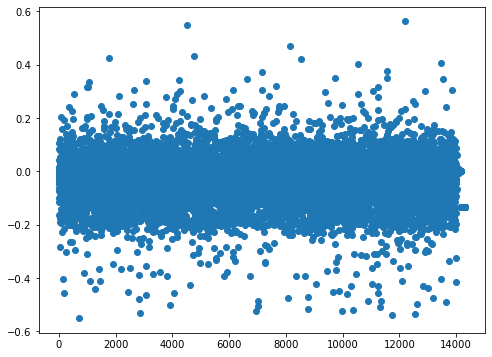

In [6]:
plt.scatter(x_axis, data[0,:,0])

## FOM data type : FOM_data = np.array[time, param, node, var]

In [7]:
FOM_data = np.zeros((num_time, num_param, num_node, num_var))

for i in range(num_var):
    for j in range(num_node):
        for k in range(num_param):
            for l in range(num_time):
                temp = l+k*num_time
                #print(l, k, temp)
                FOM_data[l,k,j,i]=data[i,j,temp]
                
FOM_data.shape

(800, 10, 14300, 1)

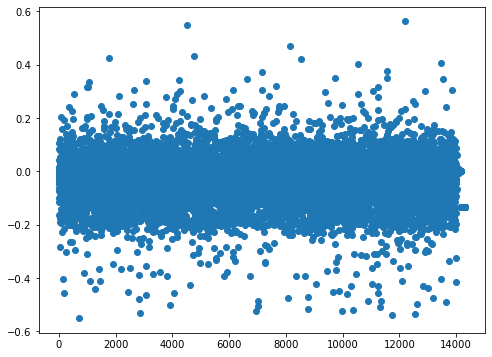

In [8]:
plt.scatter(x_axis, FOM_data[0,0,:,0])

## Scale data to [0, 1]

In [9]:
maximum = np.amax(FOM_data)
minimum = np.amin(FOM_data)
mean = np.mean(FOM_data)
AT = maximum-minimum

print(maximum)
print(minimum)
print(mean)
print(AT)

1.98040931309693
-2.50954989641887
1.361459507680192e-18
4.4899592095158


In [10]:
FOM_data = FOM_data-mean
FOM_data = FOM_data/AT
min_FOM = np.min(FOM_data)
FOM_data = FOM_data-min_FOM

print(np.max(FOM_data))
print(np.min(FOM_data))

1.0
0.0


In [11]:
FOM_data.shape

(800, 10, 14300, 1)

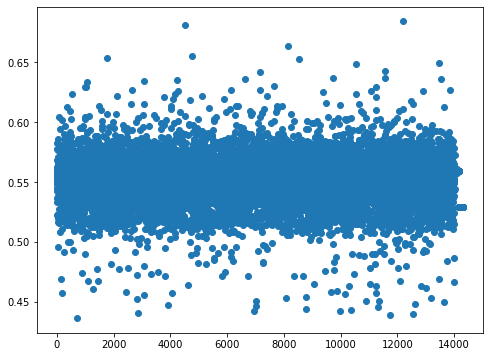

In [12]:
plt.scatter(x_axis, FOM_data[0,0,:,0])

# Level 1, SCAE (spatial CAE)

In [13]:
#Lv1_input = np.zeros((num_param*num_time, num_node, num_var))
# Lv1_input = (num_param x num_time, num_node, num_var)

Lv1_input = FOM_data.reshape(-1, num_node, num_var)
Lv1_input.shape
# Lv1_input is elongated w.r.t. param, 1,2,3,4,..../param change/1,2,3,4,.....

(8000, 14300, 1)

In [14]:
#validate

Lv1_input[200,0,0]
Lv1_input_shape_decoder = Lv1_input.shape[1]

Lv1_input_shape = Lv1_input.shape[1:]

print(Lv1_input.shape)
print(Lv1_input_shape)

(8000, 14300, 1)
(14300, 1)


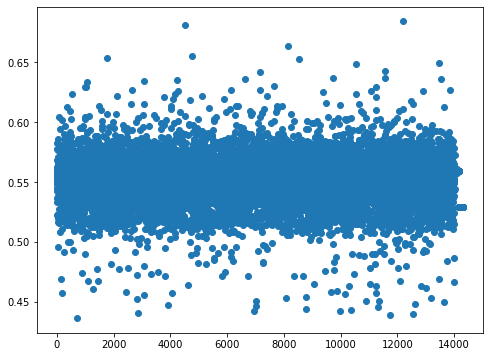

In [15]:
plt.scatter(x_axis, Lv1_input[0,:,0])

# Encoder

Model: "ENCODER"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 14300, 1)]        0         
_________________________________________________________________
conv1d (Conv1D)              (None, 14300, 64)         384       
_________________________________________________________________
batch_normalization (BatchNo (None, 14300, 64)         256       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14300, 64)         0         
_________________________________________________________________
dropout (Dropout)            (None, 14300, 64)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 14300, 128)        41088     
_________________________________________________________________
batch_normalization_1 (Batch (None, 14300, 128)        512 

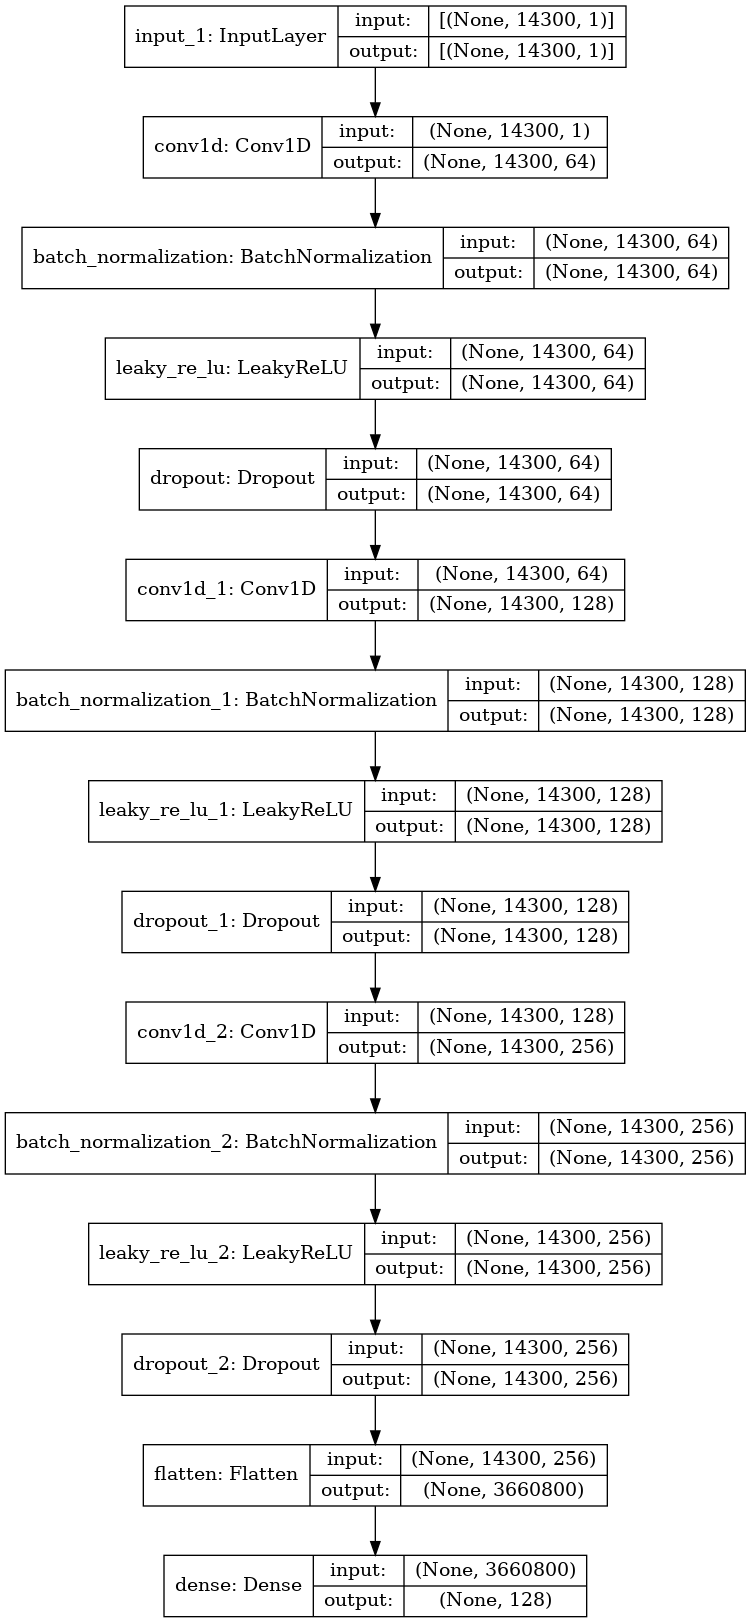

In [16]:
def encoder():
    x_input=layers.Input(shape=Lv1_input_shape)
    #x=layers.ZeroPadding1D(2)(x_input)
    
    x=layers.Conv1D(64, 5, strides=1, padding='same', kernel_initializer='glorot_uniform')(x_input)
    x=layers.BatchNormalization()(x)
    x=layers.LeakyReLU(0.2)(x)
    x=layers.Dropout(0.3)(x)
    
    x=layers.Conv1D(128, 5, strides=1, padding='same', kernel_initializer='glorot_uniform')(x)
    x=layers.BatchNormalization()(x)
    x=layers.LeakyReLU(0.2)(x)
    x=layers.Dropout(0.3)(x)   
    
    x=layers.Conv1D(256, 5, strides=1, padding='same', kernel_initializer='glorot_uniform')(x)
    x=layers.BatchNormalization()(x)
    x=layers.LeakyReLU(0.2)(x)
    x=layers.Dropout(0.3)(x)
    
    x=layers.Flatten()(x)
    x=layers.Dense(Lv1_latent_dim)(x)
    
    #mu=layers.Dense(Lv1_latent_dim, kernel_initializer='glorot_uniform')(x)
    #var=layers.Dense(Lv1_latent_dim, kernel_initializer='glorot_uniform')(x)
    #var=layers.Activation(tf.nn.softplus)(var) # var > 0
    
    #eps = tf.random.normal(shape=[Lv1_latent_dim], mean=0.0, stddev=1.0)
    #z = eps * tf.math.sqrt(var) + mu
    
    en_coder = tf.keras.models.Model(x_input, [x], name="ENCODER")
    return en_coder

Encoder=encoder()
Encoder.summary()
tf.keras.utils.plot_model(Encoder, show_shapes=True)

# Decoder

In [17]:
print(Lv1_latent_dim)
print(Lv1_input_shape_decoder)

128
14300


Model: "DECODER"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1830400)           236121600 
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 1830400)           0         
_________________________________________________________________
reshape (Reshape)            (None, 14300, 128)        0         
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 14300, 256)        131328    
_________________________________________________________________
batch_normalization_3 (Batch (None, 14300, 256)        1024      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 14300, 256)        0   

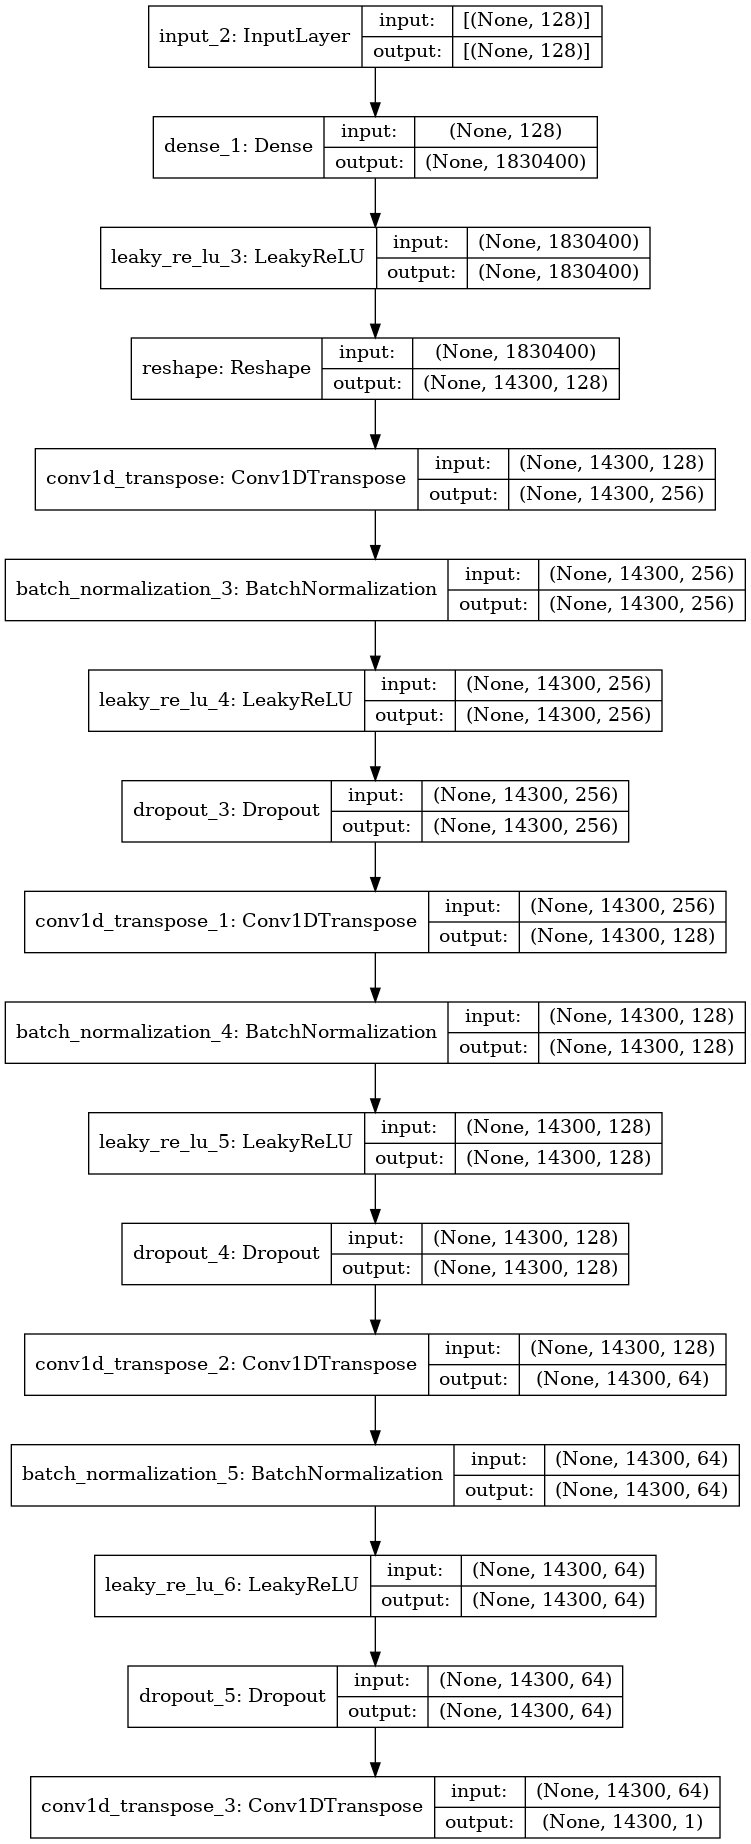

In [18]:
def decoder():
    z_input=layers.Input(shape=(Lv1_latent_dim))
    
    z=layers.Dense(Lv1_input_shape_decoder*Lv1_latent_dim, kernel_initializer='glorot_uniform')(z_input)
    z=layers.LeakyReLU(alpha=0.3)(z)
    
    z=layers.Reshape([Lv1_input_shape_decoder,Lv1_latent_dim])(z)
        
    z=layers.Conv1DTranspose(256, 4, strides=1, padding='same', kernel_initializer='glorot_uniform')(z)
    z=layers.BatchNormalization()(z)
    z=layers.LeakyReLU(alpha=0.3)(z)
    z=layers.Dropout(0.3)(z)
    
    z=layers.Conv1DTranspose(128, 4, strides=1, padding='same', kernel_initializer='glorot_uniform')(z)
    z=layers.BatchNormalization()(z)
    z=layers.LeakyReLU(alpha=0.3)(z)
    z=layers.Dropout(0.3)(z)
    
    z=layers.Conv1DTranspose(64, 4, strides=1, padding='same', kernel_initializer='glorot_uniform')(z)
    z=layers.BatchNormalization()(z)
    z=layers.LeakyReLU(alpha=0.3)(z)
    #z=layers.sigmoid(z)
    z=layers.Dropout(0.3)(z)    
    
    z=layers.Conv1DTranspose(1, 4, strides=1, activation="sigmoid",padding='same', kernel_initializer='glorot_uniform')(z)
    #z=layers.Dense(num_var)(z)
    
    
    ## Changed Dense(1, ...) to Dense(num_var, ....)
    
    #z_mu=layers.Dense(num_var, kernel_initializer='glorot_uniform')(z)
    #mu_prime=layers.Activation('tanh')(z_mu)
    
    ## Changed Dense(1, ...) to Dense(num_var, ....)
    
    #z_var=layers.Dense(num_var, kernel_initializer='glorot_uniform')(z)
    #var_prime=layers.Activation(tf.nn.softplus)(z_var) # var > 0
    
    ## I guess the 
    
    
    de_coder = tf.keras.models.Model(z_input, [z], name="DECODER")
    return de_coder

Decoder=decoder()
Decoder.summary()
tf.keras.utils.plot_model(Decoder, show_shapes=True)

# loss computation

In [19]:
def compute_loss(real_img, fake_img):
    
    reconstruction_error = tf.math.reduce_mean(tf.math.reduce_sum(tf.math.square(real_img) + tf.math.square(fake_img)))
    
    loss = reconstruction_error
    
    return loss

# CAE

In [20]:
class VAE(tf.keras.Model):
    def __init__(self, latent_dim, ENCODER, DECODER):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.ENCODER = ENCODER
        self.DECODER = DECODER
        
    def compile(self, opt, loss):
        super(VAE, self).compile()
        self.opt = opt
        self.loss = loss

    def train_step(self, real_img):
        if isinstance(data, tuple):
            real_img = real_img[0]
            
        with tf.GradientTape() as tape:
            # encoding
            latent_space = self.ENCODER(real_img, training=True)
            
            # decoding
            fake_img = self.DECODER(latent_space, training=True)
            
            # loss calculation
            loss = self.loss(real_img, fake_img)
            
        gradients = tape.gradient(loss, self.trainable_variables)
        self.opt.apply_gradients(zip(gradients, self.trainable_variables))
        return {"loss": loss}


# Save Model

In [21]:
class SaveModel(tf.keras.callbacks.Callback):
    def __init__(self, num_iter=n_epochs, latent_dim=Lv1_latent_dim):
        self.num_iter = num_iter
        self.latent_dim = Lv1_latent_dim
        
    def on_epoch_end(self, epoch, logs=None):
        if((epoch+1)%500==0):
            if((epoch+1)%500==0):          
                filename1 = 'Lv1_networks/decoder_%d.h5' % (epoch+1)
                filename2 = 'Lv1_networks/encoder_%d.h5' % (epoch+1)
                
                Decoder.save(filename1)
                Encoder.save(filename2)

# Warm up

In [22]:
beta = K.variable(0.)
N_t = int(n_epochs * 0.25)

class WarmUp(tf.keras.callbacks.Callback):
    def __init__(self, beta):
        self.beta = beta
        
    def on_epoch_begin(self, epoch, logs=None):
        if epoch < N_t:
            K.set_value(self.beta, epoch / N_t)
        else:
            K.set_value(self.beta, 1)


In [23]:
opt = tf.keras.optimizers.Adam(learning_rate=LR, beta_1=0.5, beta_2=0.99)

cbk1 = SaveModel(num_iter=n_epochs,latent_dim=Lv1_latent_dim)
cbk2 = WarmUp(beta)

vae = VAE(latent_dim=Lv1_latent_dim, ENCODER=Encoder, DECODER=Decoder)
vae.compile(opt=opt, loss=losses.MeanSquaredError())

start = time.time()
vae.fit(Lv1_input, batch_size=batch_size, epochs=n_epochs, callbacks=[cbk1, cbk2])
end = time.time()

print(end-start)

Epoch 1/20000
800/800 [==============================] - 809s 260ms/step - loss: 0.0032
Epoch 2/20000
800/800 [==============================] - 208s 259ms/step - loss: 3.1618e-04
Epoch 3/20000
800/800 [==============================] - 208s 260ms/step - loss: 2.3034e-04
Epoch 4/20000
800/800 [==============================] - 207s 259ms/step - loss: 1.6613e-04
Epoch 5/20000
800/800 [==============================] - 208s 259ms/step - loss: 1.5763e-04
Epoch 6/20000
800/800 [==============================] - 207s 259ms/step - loss: 1.2648e-04
Epoch 7/20000
800/800 [==============================] - 207s 259ms/step - loss: 1.3833e-04
Epoch 8/20000
800/800 [==============================] - 207s 259ms/step - loss: 1.1426e-04
Epoch 9/20000
800/800 [==============================] - 207s 259ms/step - loss: 1.0888e-04
Epoch 10/20000
800/800 [==============================] - 207s 259ms/step - loss: 1.0360e-04
Epoch 11/20000
800/800 [==============================] - 207s 259ms/step - loss: 9

800/800 [==============================] - 207s 259ms/step - loss: 2.4272e-05
Epoch 87/20000
800/800 [==============================] - 207s 259ms/step - loss: 2.4128e-05
Epoch 88/20000
800/800 [==============================] - 207s 259ms/step - loss: 2.3981e-05
Epoch 89/20000
800/800 [==============================] - 207s 259ms/step - loss: 2.3891e-05
Epoch 90/20000
800/800 [==============================] - 207s 259ms/step - loss: 2.3742e-05
Epoch 91/20000
800/800 [==============================] - 207s 259ms/step - loss: 2.3485e-05
Epoch 92/20000
800/800 [==============================] - 207s 259ms/step - loss: 2.3313e-05
Epoch 93/20000
800/800 [==============================] - 207s 259ms/step - loss: 2.3282e-05
Epoch 94/20000
800/800 [==============================] - 207s 259ms/step - loss: 2.3183e-05
Epoch 95/20000
800/800 [==============================] - 207s 259ms/step - loss: 2.3021e-05
Epoch 96/20000
800/800 [==============================] - 207s 259ms/step - loss: 2.2

800/800 [==============================] - 207s 259ms/step - loss: 1.9656e-05
Epoch 174/20000
800/800 [==============================] - 207s 259ms/step - loss: 1.9579e-05
Epoch 175/20000
800/800 [==============================] - 207s 259ms/step - loss: 1.9565e-05
Epoch 176/20000
800/800 [==============================] - 207s 259ms/step - loss: 1.9548e-05
Epoch 177/20000
800/800 [==============================] - 207s 259ms/step - loss: 1.9474e-05
Epoch 178/20000
800/800 [==============================] - 207s 259ms/step - loss: 1.9500e-05
Epoch 179/20000
800/800 [==============================] - 206s 257ms/step - loss: 1.9426e-05
Epoch 180/20000
800/800 [==============================] - 207s 259ms/step - loss: 1.9491e-05
Epoch 181/20000
800/800 [==============================] - 207s 259ms/step - loss: 1.9370e-05
Epoch 182/20000
800/800 [==============================] - 207s 259ms/step - loss: 1.9449e-05
Epoch 183/20000
800/800 [==============================] - 207s 259ms/step -

800/800 [==============================] - 207s 259ms/step - loss: 1.8236e-05
Epoch 261/20000
800/800 [==============================] - 207s 259ms/step - loss: 1.8210e-05
Epoch 262/20000
800/800 [==============================] - 207s 259ms/step - loss: 1.8225e-05
Epoch 263/20000
800/800 [==============================] - 207s 259ms/step - loss: 1.8212e-05
Epoch 264/20000
800/800 [==============================] - 207s 259ms/step - loss: 1.8173e-05
Epoch 265/20000
800/800 [==============================] - 207s 259ms/step - loss: 1.8203e-05
Epoch 266/20000
800/800 [==============================] - 207s 259ms/step - loss: 1.8172e-05
Epoch 267/20000
800/800 [==============================] - 207s 259ms/step - loss: 1.8214e-05
Epoch 268/20000
800/800 [==============================] - 207s 259ms/step - loss: 1.8200e-05
Epoch 269/20000
800/800 [==============================] - 207s 259ms/step - loss: 1.8166e-05
Epoch 270/20000
800/800 [==============================] - 207s 259ms/step -

800/800 [==============================] - 207s 259ms/step - loss: 1.7668e-05
Epoch 348/20000
800/800 [==============================] - 207s 259ms/step - loss: 1.7697e-05
Epoch 349/20000
800/800 [==============================] - 207s 259ms/step - loss: 1.7643e-05
Epoch 350/20000
800/800 [==============================] - 207s 259ms/step - loss: 1.7733e-05
Epoch 351/20000
800/800 [==============================] - 207s 259ms/step - loss: 1.7661e-05
Epoch 352/20000
800/800 [==============================] - 207s 259ms/step - loss: 1.7644e-05
Epoch 353/20000
800/800 [==============================] - 207s 259ms/step - loss: 1.7612e-05
Epoch 354/20000
800/800 [==============================] - 207s 259ms/step - loss: 1.7685e-05
Epoch 355/20000
800/800 [==============================] - 207s 259ms/step - loss: 1.7636e-05
Epoch 356/20000
800/800 [==============================] - 207s 259ms/step - loss: 1.7622e-05
Epoch 357/20000
800/800 [==============================] - 207s 259ms/step -

800/800 [==============================] - 143s 179ms/step - loss: 1.7384e-05
Epoch 435/20000
800/800 [==============================] - 143s 178ms/step - loss: 1.7390e-05
Epoch 436/20000
800/800 [==============================] - 143s 179ms/step - loss: 1.7373e-05
Epoch 437/20000
800/800 [==============================] - 143s 178ms/step - loss: 1.7408e-05
Epoch 438/20000
800/800 [==============================] - 143s 179ms/step - loss: 1.7368e-05
Epoch 439/20000
800/800 [==============================] - 143s 179ms/step - loss: 1.7300e-05
Epoch 440/20000
800/800 [==============================] - 143s 179ms/step - loss: 1.7329e-05
Epoch 441/20000
800/800 [==============================] - 143s 179ms/step - loss: 1.7318e-05
Epoch 442/20000
800/800 [==============================] - 143s 178ms/step - loss: 1.7314e-05
Epoch 443/20000
800/800 [==============================] - 143s 178ms/step - loss: 1.7380e-05
Epoch 444/20000
800/800 [==============================] - 143s 179ms/step -

800/800 [==============================] - 95s 119ms/step - loss: 1.7118e-05
Epoch 519/20000
800/800 [==============================] - 95s 119ms/step - loss: 1.7159e-05
Epoch 520/20000
800/800 [==============================] - 95s 119ms/step - loss: 1.7139e-05
Epoch 521/20000
800/800 [==============================] - 95s 119ms/step - loss: 1.7179e-05
Epoch 522/20000
800/800 [==============================] - 95s 119ms/step - loss: 1.7158e-05
Epoch 523/20000
800/800 [==============================] - 95s 119ms/step - loss: 1.7062e-05
Epoch 524/20000
800/800 [==============================] - 95s 119ms/step - loss: 1.7125e-05
Epoch 525/20000
800/800 [==============================] - 95s 119ms/step - loss: 1.7109e-05
Epoch 526/20000
800/800 [==============================] - 95s 119ms/step - loss: 1.7088e-05
Epoch 527/20000
800/800 [==============================] - 95s 119ms/step - loss: 1.7066e-05
Epoch 528/20000
800/800 [==============================] - 95s 119ms/step - loss: 1.70

800/800 [==============================] - 95s 119ms/step - loss: 1.6902e-05
Epoch 607/20000
800/800 [==============================] - 95s 119ms/step - loss: 1.6975e-05
Epoch 608/20000
800/800 [==============================] - 95s 119ms/step - loss: 1.6864e-05
Epoch 609/20000
800/800 [==============================] - 95s 119ms/step - loss: 1.6961e-05
Epoch 610/20000
800/800 [==============================] - 95s 119ms/step - loss: 1.6885e-05
Epoch 611/20000
800/800 [==============================] - 95s 119ms/step - loss: 1.6930e-05
Epoch 612/20000
800/800 [==============================] - 95s 119ms/step - loss: 1.6858e-05
Epoch 613/20000
800/800 [==============================] - 95s 119ms/step - loss: 1.6880e-05
Epoch 614/20000
800/800 [==============================] - 95s 119ms/step - loss: 1.6900e-05
Epoch 615/20000
800/800 [==============================] - 95s 119ms/step - loss: 1.6856e-05
Epoch 616/20000
800/800 [==============================] - 95s 119ms/step - loss: 1.69

800/800 [==============================] - 95s 119ms/step - loss: 1.6753e-05
Epoch 695/20000
800/800 [==============================] - 95s 119ms/step - loss: 1.6792e-05
Epoch 696/20000
800/800 [==============================] - 95s 119ms/step - loss: 1.6801e-05
Epoch 697/20000
800/800 [==============================] - 95s 119ms/step - loss: 1.6781e-05
Epoch 698/20000
800/800 [==============================] - 95s 119ms/step - loss: 1.6824e-05
Epoch 699/20000
800/800 [==============================] - 95s 119ms/step - loss: 1.6759e-05
Epoch 700/20000
800/800 [==============================] - 95s 119ms/step - loss: 1.6799e-05
Epoch 701/20000
800/800 [==============================] - 95s 119ms/step - loss: 1.6739e-05
Epoch 702/20000
800/800 [==============================] - 95s 119ms/step - loss: 1.6814e-05
Epoch 703/20000
800/800 [==============================] - 95s 119ms/step - loss: 1.6805e-05
Epoch 704/20000
800/800 [==============================] - 95s 119ms/step - loss: 1.67

800/800 [==============================] - 95s 119ms/step - loss: 1.6675e-05
Epoch 783/20000
800/800 [==============================] - 95s 119ms/step - loss: 1.6661e-05
Epoch 784/20000
800/800 [==============================] - 95s 119ms/step - loss: 1.6673e-05
Epoch 785/20000
800/800 [==============================] - 95s 119ms/step - loss: 1.6759e-05
Epoch 786/20000
800/800 [==============================] - 95s 119ms/step - loss: 1.6614e-05
Epoch 787/20000
800/800 [==============================] - 95s 119ms/step - loss: 1.6666e-05
Epoch 788/20000
800/800 [==============================] - 95s 119ms/step - loss: 1.6720e-05
Epoch 789/20000
800/800 [==============================] - 95s 119ms/step - loss: 1.6705e-05
Epoch 790/20000
800/800 [==============================] - 95s 119ms/step - loss: 1.6730e-05
Epoch 791/20000
800/800 [==============================] - 95s 119ms/step - loss: 1.6754e-05
Epoch 792/20000
800/800 [==============================] - 95s 119ms/step - loss: 1.66

800/800 [==============================] - 95s 119ms/step - loss: 1.6605e-05
Epoch 871/20000
800/800 [==============================] - 95s 119ms/step - loss: 1.6597e-05
Epoch 872/20000
800/800 [==============================] - 95s 119ms/step - loss: 1.6552e-05
Epoch 873/20000
800/800 [==============================] - 95s 119ms/step - loss: 1.6542e-05
Epoch 874/20000
800/800 [==============================] - 95s 119ms/step - loss: 1.6550e-05
Epoch 875/20000
800/800 [==============================] - 95s 119ms/step - loss: 1.6583e-05
Epoch 876/20000
800/800 [==============================] - 95s 119ms/step - loss: 1.6586e-05
Epoch 877/20000
800/800 [==============================] - 95s 119ms/step - loss: 1.6557e-05
Epoch 878/20000
800/800 [==============================] - 95s 119ms/step - loss: 1.6554e-05
Epoch 879/20000
800/800 [==============================] - 95s 119ms/step - loss: 1.6536e-05
Epoch 880/20000
800/800 [==============================] - 95s 119ms/step - loss: 1.65

800/800 [==============================] - 95s 119ms/step - loss: 1.6497e-05
Epoch 959/20000
800/800 [==============================] - 95s 119ms/step - loss: 1.6530e-05
Epoch 960/20000
800/800 [==============================] - 95s 119ms/step - loss: 1.6510e-05
Epoch 961/20000
800/800 [==============================] - 95s 119ms/step - loss: 1.6496e-05
Epoch 962/20000
800/800 [==============================] - 95s 119ms/step - loss: 1.6483e-05
Epoch 963/20000
800/800 [==============================] - 95s 119ms/step - loss: 1.6467e-05
Epoch 964/20000
800/800 [==============================] - 95s 119ms/step - loss: 1.6437e-05
Epoch 965/20000
800/800 [==============================] - 95s 119ms/step - loss: 1.6432e-05
Epoch 966/20000
800/800 [==============================] - 95s 119ms/step - loss: 1.6488e-05
Epoch 967/20000
800/800 [==============================] - 95s 119ms/step - loss: 1.6444e-05
Epoch 968/20000
800/800 [==============================] - 95s 119ms/step - loss: 1.64

800/800 [==============================] - 95s 119ms/step - loss: 1.6391e-05
Epoch 1043/20000
800/800 [==============================] - 95s 119ms/step - loss: 1.6444e-05
Epoch 1044/20000
800/800 [==============================] - 95s 119ms/step - loss: 1.6392e-05
Epoch 1045/20000
800/800 [==============================] - 95s 119ms/step - loss: 1.6400e-05
Epoch 1046/20000
800/800 [==============================] - 95s 119ms/step - loss: 1.6422e-05
Epoch 1047/20000
800/800 [==============================] - 95s 119ms/step - loss: 1.6372e-05
Epoch 1048/20000
800/800 [==============================] - 95s 119ms/step - loss: 1.6460e-05
Epoch 1049/20000
800/800 [==============================] - 95s 119ms/step - loss: 1.6396e-05
Epoch 1050/20000
800/800 [==============================] - 95s 119ms/step - loss: 1.6433e-05
Epoch 1051/20000
800/800 [==============================] - 95s 119ms/step - loss: 1.6355e-05
Epoch 1052/20000
800/800 [==============================] - 95s 119ms/step - 

800/800 [==============================] - 95s 119ms/step - loss: 1.6330e-05
Epoch 1130/20000
800/800 [==============================] - 95s 119ms/step - loss: 1.6436e-05
Epoch 1131/20000
800/800 [==============================] - 95s 119ms/step - loss: 1.6336e-05
Epoch 1132/20000
800/800 [==============================] - 95s 119ms/step - loss: 1.6320e-05
Epoch 1133/20000
800/800 [==============================] - 95s 119ms/step - loss: 1.6357e-05
Epoch 1134/20000
800/800 [==============================] - 95s 119ms/step - loss: 1.6293e-05
Epoch 1135/20000
800/800 [==============================] - 95s 119ms/step - loss: 1.6302e-05
Epoch 1136/20000
800/800 [==============================] - 95s 119ms/step - loss: 1.6301e-05
Epoch 1137/20000
800/800 [==============================] - 95s 119ms/step - loss: 1.6364e-05
Epoch 1138/20000
800/800 [==============================] - 95s 119ms/step - loss: 1.6346e-05
Epoch 1139/20000
800/800 [==============================] - 95s 119ms/step - 

800/800 [==============================] - 95s 119ms/step - loss: 1.6308e-05
Epoch 1217/20000
800/800 [==============================] - 95s 119ms/step - loss: 1.6278e-05
Epoch 1218/20000
800/800 [==============================] - 95s 119ms/step - loss: 1.6295e-05
Epoch 1219/20000
800/800 [==============================] - 95s 119ms/step - loss: 1.6298e-05
Epoch 1220/20000
800/800 [==============================] - 95s 119ms/step - loss: 1.6257e-05
Epoch 1221/20000
800/800 [==============================] - 95s 119ms/step - loss: 1.6240e-05
Epoch 1222/20000
800/800 [==============================] - 95s 119ms/step - loss: 1.6264e-05
Epoch 1223/20000
800/800 [==============================] - 95s 119ms/step - loss: 1.6278e-05
Epoch 1224/20000
800/800 [==============================] - 95s 119ms/step - loss: 1.6292e-05
Epoch 1225/20000
800/800 [==============================] - 95s 119ms/step - loss: 1.6263e-05
Epoch 1226/20000
800/800 [==============================] - 95s 119ms/step - 

800/800 [==============================] - 95s 119ms/step - loss: 1.6278e-05
Epoch 1304/20000
800/800 [==============================] - 95s 119ms/step - loss: 1.6207e-05
Epoch 1305/20000
800/800 [==============================] - 95s 119ms/step - loss: 1.6206e-05
Epoch 1306/20000
800/800 [==============================] - 131s 164ms/step - loss: 1.6209e-05
Epoch 1307/20000
800/800 [==============================] - 205s 256ms/step - loss: 1.6250e-05
Epoch 1308/20000
800/800 [==============================] - 205s 256ms/step - loss: 1.6255e-05
Epoch 1309/20000
800/800 [==============================] - 205s 256ms/step - loss: 1.6266e-05
Epoch 1310/20000
800/800 [==============================] - 205s 256ms/step - loss: 1.6281e-05
Epoch 1311/20000
800/800 [==============================] - 206s 257ms/step - loss: 1.6247e-05
Epoch 1312/20000
800/800 [==============================] - 205s 256ms/step - loss: 1.6282e-05
Epoch 1313/20000
800/800 [==============================] - 205s 256ms

800/800 [==============================] - 205s 256ms/step - loss: 1.6161e-05
Epoch 1390/20000
800/800 [==============================] - 205s 256ms/step - loss: 1.6180e-05
Epoch 1391/20000
800/800 [==============================] - 205s 257ms/step - loss: 1.6192e-05
Epoch 1392/20000
800/800 [==============================] - 205s 256ms/step - loss: 1.6166e-05
Epoch 1393/20000
800/800 [==============================] - 206s 257ms/step - loss: 1.6185e-05
Epoch 1394/20000
800/800 [==============================] - 205s 256ms/step - loss: 1.6166e-05
Epoch 1395/20000
800/800 [==============================] - 205s 256ms/step - loss: 1.6190e-05
Epoch 1396/20000
800/800 [==============================] - 205s 257ms/step - loss: 1.6188e-05
Epoch 1397/20000
800/800 [==============================] - 205s 256ms/step - loss: 1.6212e-05
Epoch 1398/20000
800/800 [==============================] - 205s 257ms/step - loss: 1.6190e-05
Epoch 1399/20000
800/800 [==============================] - 205s 25

800/800 [==============================] - 205s 256ms/step - loss: 1.6229e-05
Epoch 1476/20000
800/800 [==============================] - 205s 256ms/step - loss: 1.6152e-05
Epoch 1477/20000
800/800 [==============================] - 205s 256ms/step - loss: 1.6144e-05
Epoch 1478/20000
800/800 [==============================] - 205s 256ms/step - loss: 1.6134e-05
Epoch 1479/20000
800/800 [==============================] - 205s 256ms/step - loss: 1.6147e-05
Epoch 1480/20000
800/800 [==============================] - 205s 256ms/step - loss: 1.6163e-05
Epoch 1481/20000
800/800 [==============================] - 205s 256ms/step - loss: 1.6142e-05
Epoch 1482/20000
800/800 [==============================] - 205s 256ms/step - loss: 1.6136e-05
Epoch 1483/20000
800/800 [==============================] - 205s 256ms/step - loss: 1.6096e-05
Epoch 1484/20000
800/800 [==============================] - 205s 256ms/step - loss: 1.6157e-05
Epoch 1485/20000
800/800 [==============================] - 205s 25

800/800 [==============================] - 204s 255ms/step - loss: 1.6105e-05
Epoch 1558/20000
800/800 [==============================] - 204s 255ms/step - loss: 1.6091e-05
Epoch 1559/20000
800/800 [==============================] - 204s 255ms/step - loss: 1.6068e-05
Epoch 1560/20000
800/800 [==============================] - 205s 256ms/step - loss: 1.6153e-05
Epoch 1561/20000
800/800 [==============================] - 205s 256ms/step - loss: 1.6065e-05
Epoch 1562/20000
800/800 [==============================] - 204s 255ms/step - loss: 1.6110e-05
Epoch 1563/20000
800/800 [==============================] - 205s 256ms/step - loss: 1.6138e-05
Epoch 1564/20000
800/800 [==============================] - 205s 256ms/step - loss: 1.6087e-05
Epoch 1565/20000
800/800 [==============================] - 205s 256ms/step - loss: 1.6090e-05
Epoch 1566/20000
800/800 [==============================] - 205s 256ms/step - loss: 1.6128e-05
Epoch 1567/20000
800/800 [==============================] - 203s 25

800/800 [==============================] - 205s 256ms/step - loss: 1.6073e-05
Epoch 1644/20000
800/800 [==============================] - 205s 257ms/step - loss: 1.6056e-05
Epoch 1645/20000
800/800 [==============================] - 205s 256ms/step - loss: 1.6065e-05
Epoch 1646/20000
800/800 [==============================] - 205s 256ms/step - loss: 1.6141e-05
Epoch 1647/20000
800/800 [==============================] - 204s 256ms/step - loss: 1.6054e-05
Epoch 1648/20000
800/800 [==============================] - 205s 256ms/step - loss: 1.6037e-05
Epoch 1649/20000
800/800 [==============================] - 205s 256ms/step - loss: 1.6056e-05
Epoch 1650/20000
800/800 [==============================] - 204s 255ms/step - loss: 1.6049e-05
Epoch 1651/20000
800/800 [==============================] - 205s 256ms/step - loss: 1.6054e-05
Epoch 1652/20000
800/800 [==============================] - 205s 256ms/step - loss: 1.6044e-05
Epoch 1653/20000
800/800 [==============================] - 205s 25

800/800 [==============================] - 204s 255ms/step - loss: 1.6052e-05
Epoch 1730/20000
800/800 [==============================] - 204s 254ms/step - loss: 1.6025e-05
Epoch 1731/20000
800/800 [==============================] - 204s 255ms/step - loss: 1.6078e-05
Epoch 1732/20000
800/800 [==============================] - 204s 255ms/step - loss: 1.6043e-05
Epoch 1733/20000
800/800 [==============================] - 204s 255ms/step - loss: 1.6027e-05
Epoch 1734/20000
800/800 [==============================] - 204s 255ms/step - loss: 1.6030e-05
Epoch 1735/20000
800/800 [==============================] - 205s 256ms/step - loss: 1.6022e-05
Epoch 1736/20000
800/800 [==============================] - 204s 255ms/step - loss: 1.6096e-05
Epoch 1737/20000
800/800 [==============================] - 204s 255ms/step - loss: 1.5965e-05
Epoch 1738/20000
800/800 [==============================] - 204s 255ms/step - loss: 1.6041e-05
Epoch 1739/20000
800/800 [==============================] - 204s 25

800/800 [==============================] - 204s 255ms/step - loss: 1.6040e-05
Epoch 1816/20000
800/800 [==============================] - 205s 256ms/step - loss: 1.6024e-05
Epoch 1817/20000
800/800 [==============================] - 204s 255ms/step - loss: 1.5982e-05
Epoch 1818/20000
800/800 [==============================] - 205s 256ms/step - loss: 1.6072e-05
Epoch 1819/20000
800/800 [==============================] - 204s 255ms/step - loss: 1.6002e-05
Epoch 1820/20000
800/800 [==============================] - 204s 256ms/step - loss: 1.6035e-05
Epoch 1821/20000
800/800 [==============================] - 205s 256ms/step - loss: 1.5997e-05
Epoch 1822/20000
800/800 [==============================] - 205s 256ms/step - loss: 1.6034e-05
Epoch 1823/20000
800/800 [==============================] - 205s 256ms/step - loss: 1.6021e-05
Epoch 1824/20000
800/800 [==============================] - 204s 255ms/step - loss: 1.5989e-05
Epoch 1825/20000
800/800 [==============================] - 205s 25

800/800 [==============================] - 204s 255ms/step - loss: 1.6032e-05
Epoch 1902/20000
800/800 [==============================] - 204s 255ms/step - loss: 1.5993e-05
Epoch 1903/20000
800/800 [==============================] - 205s 256ms/step - loss: 1.5992e-05
Epoch 1904/20000
800/800 [==============================] - 204s 255ms/step - loss: 1.5956e-05
Epoch 1905/20000
800/800 [==============================] - 205s 256ms/step - loss: 1.6002e-05
Epoch 1906/20000
800/800 [==============================] - 204s 255ms/step - loss: 1.5987e-05
Epoch 1907/20000
800/800 [==============================] - 204s 255ms/step - loss: 1.6002e-05
Epoch 1908/20000
800/800 [==============================] - 204s 255ms/step - loss: 1.5948e-05
Epoch 1909/20000
800/800 [==============================] - 204s 255ms/step - loss: 1.6020e-05
Epoch 1910/20000
800/800 [==============================] - 205s 256ms/step - loss: 1.6017e-05
Epoch 1911/20000
800/800 [==============================] - 204s 25

800/800 [==============================] - 204s 256ms/step - loss: 1.5982e-05
Epoch 1988/20000
800/800 [==============================] - 204s 255ms/step - loss: 1.5972e-05
Epoch 1989/20000
800/800 [==============================] - 204s 255ms/step - loss: 1.5946e-05
Epoch 1990/20000
800/800 [==============================] - 205s 256ms/step - loss: 1.5975e-05
Epoch 1991/20000
800/800 [==============================] - 204s 255ms/step - loss: 1.5963e-05
Epoch 1992/20000
800/800 [==============================] - 205s 256ms/step - loss: 1.5998e-05
Epoch 1993/20000
800/800 [==============================] - 204s 255ms/step - loss: 1.5994e-05
Epoch 1994/20000
800/800 [==============================] - 205s 256ms/step - loss: 1.6040e-05
Epoch 1995/20000
800/800 [==============================] - 204s 255ms/step - loss: 1.5975e-05
Epoch 1996/20000
800/800 [==============================] - 205s 256ms/step - loss: 1.5965e-05
Epoch 1997/20000
800/800 [==============================] - 205s 25

800/800 [==============================] - 204s 255ms/step - loss: 1.5913e-05
Epoch 2070/20000
800/800 [==============================] - 205s 256ms/step - loss: 1.5917e-05
Epoch 2071/20000
800/800 [==============================] - 204s 255ms/step - loss: 1.5951e-05
Epoch 2072/20000
800/800 [==============================] - 204s 255ms/step - loss: 1.5928e-05
Epoch 2073/20000
800/800 [==============================] - 204s 256ms/step - loss: 1.5898e-05
Epoch 2074/20000
800/800 [==============================] - 205s 256ms/step - loss: 1.5914e-05
Epoch 2075/20000
800/800 [==============================] - 204s 255ms/step - loss: 1.5912e-05
Epoch 2076/20000
800/800 [==============================] - 204s 256ms/step - loss: 1.5880e-05
Epoch 2077/20000
800/800 [==============================] - 204s 255ms/step - loss: 1.5924e-05
Epoch 2078/20000
800/800 [==============================] - 204s 255ms/step - loss: 1.5927e-05
Epoch 2079/20000
800/800 [==============================] - 205s 25

800/800 [==============================] - 205s 256ms/step - loss: 1.5924e-05
Epoch 2156/20000
800/800 [==============================] - 204s 256ms/step - loss: 1.5936e-05
Epoch 2157/20000
800/800 [==============================] - 205s 256ms/step - loss: 1.5902e-05
Epoch 2158/20000
800/800 [==============================] - 205s 256ms/step - loss: 1.5948e-05
Epoch 2159/20000
800/800 [==============================] - 205s 257ms/step - loss: 1.5870e-05
Epoch 2160/20000
800/800 [==============================] - 205s 256ms/step - loss: 1.6027e-05
Epoch 2161/20000
800/800 [==============================] - 205s 256ms/step - loss: 1.5885e-05
Epoch 2162/20000
800/800 [==============================] - 204s 256ms/step - loss: 1.5964e-05
Epoch 2163/20000
800/800 [==============================] - 204s 256ms/step - loss: 1.5887e-05
Epoch 2164/20000
800/800 [==============================] - 205s 256ms/step - loss: 1.5937e-05
Epoch 2165/20000
800/800 [==============================] - 205s 25

800/800 [==============================] - 205s 256ms/step - loss: 1.5871e-05
Epoch 2242/20000
800/800 [==============================] - 205s 256ms/step - loss: 1.5866e-05
Epoch 2243/20000
800/800 [==============================] - 205s 256ms/step - loss: 1.5935e-05
Epoch 2244/20000
800/800 [==============================] - 205s 256ms/step - loss: 1.5902e-05
Epoch 2245/20000
800/800 [==============================] - 204s 256ms/step - loss: 1.5851e-05
Epoch 2246/20000
800/800 [==============================] - 205s 256ms/step - loss: 1.5928e-05
Epoch 2247/20000
800/800 [==============================] - 203s 253ms/step - loss: 1.5897e-05
Epoch 2248/20000
800/800 [==============================] - 204s 255ms/step - loss: 1.5908e-05
Epoch 2249/20000
800/800 [==============================] - 205s 256ms/step - loss: 1.5909e-05
Epoch 2250/20000
800/800 [==============================] - 204s 255ms/step - loss: 1.5933e-05
Epoch 2251/20000
800/800 [==============================] - 205s 25

800/800 [==============================] - 204s 255ms/step - loss: 1.5828e-05
Epoch 2328/20000
800/800 [==============================] - 204s 255ms/step - loss: 1.5860e-05
Epoch 2329/20000
800/800 [==============================] - 204s 255ms/step - loss: 1.5889e-05
Epoch 2330/20000
800/800 [==============================] - 204s 255ms/step - loss: 1.5850e-05
Epoch 2331/20000
800/800 [==============================] - 204s 255ms/step - loss: 1.5878e-05
Epoch 2332/20000
800/800 [==============================] - 204s 255ms/step - loss: 1.5863e-05
Epoch 2333/20000
800/800 [==============================] - 204s 255ms/step - loss: 1.5909e-05
Epoch 2334/20000
800/800 [==============================] - 204s 255ms/step - loss: 1.5904e-05
Epoch 2335/20000
800/800 [==============================] - 204s 255ms/step - loss: 1.5851e-05
Epoch 2336/20000
800/800 [==============================] - 205s 256ms/step - loss: 1.5907e-05
Epoch 2337/20000
800/800 [==============================] - 204s 25

800/800 [==============================] - 204s 256ms/step - loss: 1.5866e-05
Epoch 2414/20000
800/800 [==============================] - 205s 256ms/step - loss: 1.5850e-05
Epoch 2415/20000
800/800 [==============================] - 205s 256ms/step - loss: 1.5873e-05
Epoch 2416/20000
800/800 [==============================] - 204s 255ms/step - loss: 1.5856e-05
Epoch 2417/20000
800/800 [==============================] - 205s 256ms/step - loss: 1.5861e-05
Epoch 2418/20000
800/800 [==============================] - 204s 255ms/step - loss: 1.5862e-05
Epoch 2419/20000
800/800 [==============================] - 204s 255ms/step - loss: 1.5837e-05
Epoch 2420/20000
800/800 [==============================] - 204s 255ms/step - loss: 1.5799e-05
Epoch 2421/20000
800/800 [==============================] - 204s 255ms/step - loss: 1.5851e-05
Epoch 2422/20000
800/800 [==============================] - 204s 255ms/step - loss: 1.5856e-05
Epoch 2423/20000
800/800 [==============================] - 205s 25

800/800 [==============================] - 204s 255ms/step - loss: 1.5865e-05
Epoch 2500/20000
800/800 [==============================] - 204s 255ms/step - loss: 1.5831e-05
Epoch 2501/20000
800/800 [==============================] - 204s 255ms/step - loss: 1.5822e-05
Epoch 2502/20000
800/800 [==============================] - 204s 256ms/step - loss: 1.5831e-05
Epoch 2503/20000
800/800 [==============================] - 204s 255ms/step - loss: 1.5819e-05
Epoch 2504/20000
800/800 [==============================] - 205s 256ms/step - loss: 1.5834e-05
Epoch 2505/20000
800/800 [==============================] - 205s 256ms/step - loss: 1.5872e-05
Epoch 2506/20000
800/800 [==============================] - 204s 255ms/step - loss: 1.5832e-05
Epoch 2507/20000
800/800 [==============================] - 205s 256ms/step - loss: 1.5853e-05
Epoch 2508/20000
800/800 [==============================] - 204s 255ms/step - loss: 1.5853e-05
Epoch 2509/20000
800/800 [==============================] - 203s 25

800/800 [==============================] - 204s 256ms/step - loss: 1.5834e-05
Epoch 2582/20000
800/800 [==============================] - 205s 256ms/step - loss: 1.5777e-05
Epoch 2583/20000
800/800 [==============================] - 205s 256ms/step - loss: 1.5802e-05
Epoch 2584/20000
800/800 [==============================] - 205s 256ms/step - loss: 1.5832e-05
Epoch 2585/20000
800/800 [==============================] - 205s 256ms/step - loss: 1.5799e-05
Epoch 2586/20000
800/800 [==============================] - 205s 256ms/step - loss: 1.5773e-05
Epoch 2587/20000
800/800 [==============================] - 204s 256ms/step - loss: 1.5845e-05
Epoch 2588/20000
800/800 [==============================] - 205s 256ms/step - loss: 1.5813e-05
Epoch 2589/20000
800/800 [==============================] - 205s 256ms/step - loss: 1.5822e-05
Epoch 2590/20000
800/800 [==============================] - 204s 256ms/step - loss: 1.5812e-05
Epoch 2591/20000
800/800 [==============================] - 205s 25

800/800 [==============================] - 205s 256ms/step - loss: 1.5799e-05
Epoch 2668/20000
800/800 [==============================] - 204s 255ms/step - loss: 1.5822e-05
Epoch 2669/20000
800/800 [==============================] - 205s 256ms/step - loss: 1.5778e-05
Epoch 2670/20000
800/800 [==============================] - 204s 256ms/step - loss: 1.5807e-05
Epoch 2671/20000
800/800 [==============================] - 205s 256ms/step - loss: 1.5826e-05
Epoch 2672/20000
800/800 [==============================] - 205s 256ms/step - loss: 1.5835e-05
Epoch 2673/20000
800/800 [==============================] - 205s 256ms/step - loss: 1.5833e-05
Epoch 2674/20000
800/800 [==============================] - 205s 256ms/step - loss: 1.5809e-05
Epoch 2675/20000
800/800 [==============================] - 205s 256ms/step - loss: 1.5816e-05
Epoch 2676/20000
800/800 [==============================] - 205s 256ms/step - loss: 1.5781e-05
Epoch 2677/20000
800/800 [==============================] - 205s 25

800/800 [==============================] - 204s 255ms/step - loss: 1.5825e-05
Epoch 2754/20000
800/800 [==============================] - 204s 255ms/step - loss: 1.5761e-05
Epoch 2755/20000
800/800 [==============================] - 204s 255ms/step - loss: 1.5819e-05
Epoch 2756/20000
800/800 [==============================] - 205s 256ms/step - loss: 1.5809e-05
Epoch 2757/20000
800/800 [==============================] - 204s 255ms/step - loss: 1.5755e-05
Epoch 2758/20000
800/800 [==============================] - 205s 256ms/step - loss: 1.5797e-05
Epoch 2759/20000
800/800 [==============================] - 204s 255ms/step - loss: 1.5847e-05
Epoch 2760/20000
800/800 [==============================] - 204s 255ms/step - loss: 1.5803e-05
Epoch 2761/20000
800/800 [==============================] - 204s 256ms/step - loss: 1.5824e-05
Epoch 2762/20000
800/800 [==============================] - 204s 255ms/step - loss: 1.5803e-05
Epoch 2763/20000
800/800 [==============================] - 204s 25

800/800 [==============================] - 204s 255ms/step - loss: 1.5784e-05
Epoch 2840/20000
800/800 [==============================] - 204s 255ms/step - loss: 1.5775e-05
Epoch 2841/20000
800/800 [==============================] - 204s 255ms/step - loss: 1.5794e-05
Epoch 2842/20000
800/800 [==============================] - 204s 255ms/step - loss: 1.5782e-05
Epoch 2843/20000
800/800 [==============================] - 204s 256ms/step - loss: 1.5765e-05
Epoch 2844/20000
800/800 [==============================] - 204s 255ms/step - loss: 1.5774e-05
Epoch 2845/20000
800/800 [==============================] - 204s 255ms/step - loss: 1.5782e-05
Epoch 2846/20000
800/800 [==============================] - 204s 255ms/step - loss: 1.5756e-05
Epoch 2847/20000
800/800 [==============================] - 204s 255ms/step - loss: 1.5766e-05
Epoch 2848/20000
800/800 [==============================] - 204s 256ms/step - loss: 1.5821e-05
Epoch 2849/20000
800/800 [==============================] - 204s 25

KeyboardInterrupt: 

# Acquire latent vectors